# PA2 - Structure from Motion
---
- 20204102 Juhyeon Nam (AI Graduate School)

In [1]:
import os
DATASET_dir = os.path.join(os.getcwd(),'data_2_sfm')
DATASET_dir

'/home/njh/Desktop/CV2020/PA2/data_2_sfm'

In [2]:
import cv2
cv2.__version__

'4.4.0'

## Correspondence Search, Relating Images
---
1. Extract SIFT from every image and find putative matches
2. Reject outliers by RANSAC

### 1. Extract SIFT from every image and find putative matches

Since this step is same as the task 1 from PA1, I modified the `alignImages()` function from the PA1 with SIFT descriptor.

Also, I referenced the code from [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html)

I rather not to filter the SIFT feature matching much, since the bad matches will be rejected from RANSAC later. So I used 0.9 for the good match percent. 

In [3]:
import matplotlib.pyplot as plt

GOOD_MATCH_PERCENT = 0.9

def SIFT_feature_matching(im1, im2):
    
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    
    # Detect SIFT features and compute descriptors
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(im2Gray, None)
    
    # Match features
    matcher  = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)
    
    # Drop bad matches
    good_matches = []
    for m, n in matches:
        if m.distance < GOOD_MATCH_PERCENT*n.distance:
            good_matches.append([m])

    # Draw top matches
    imMatches = cv2.drawMatchesKnn(im1, keypoints1, im2, keypoints2, good_matches, None)
    cv2.imwrite("matches.jpg", imMatches)
    
    plt.figure(figsize=(16,8))
    plt.suptitle('SIFT Feature matching')
    plt.imshow(cv2.cvtColor(imMatches, cv2.COLOR_BGR2RGB))
    
    return keypoints1, keypoints2, good_matches

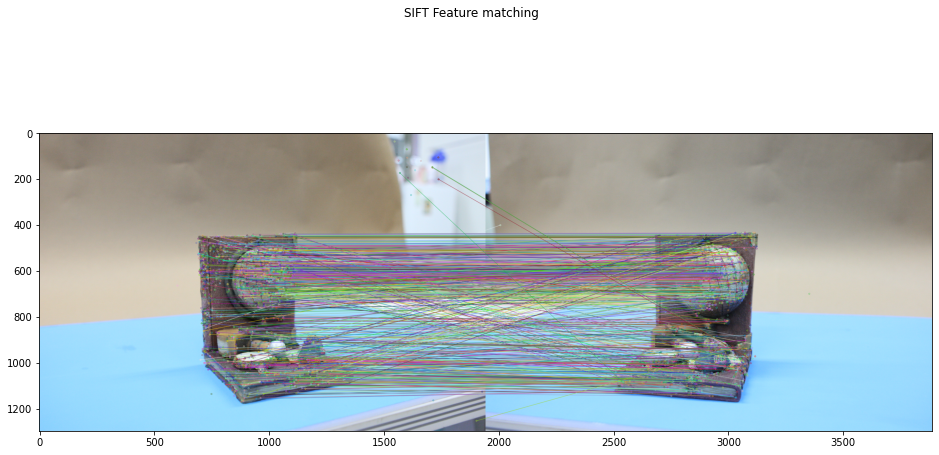

In [4]:
img1 = cv2.imread(os.path.join(DATASET_dir, 'sfm01.JPG'), cv2.IMREAD_COLOR)
img2 = cv2.imread(os.path.join(DATASET_dir, 'sfm02.JPG'), cv2.IMREAD_COLOR)

keypoints1, keypoints2, good_matches = SIFT_feature_matching(img1, img2)

### 2. Estimating essential matrix with RANSAC

To calculate the essential matrix, I randomly choose 5 matched points from the SIFT feature matching for 5 points algorithm which is a given function in `calibrated_five_point.m`. First, The points should be converted into normalized coordinate for calculated essential matirx. Therefore, I multiplied inverse of K to the matched points. 

For RANSAC, we need to measure the distance between epipolar line and the matched point in another image. Where the epipolar line is denoted by <img src="https://render.githubusercontent.com/render/math?math=Fx=[a\ b\ c]">, the distance between the epipolar line and the matched point <img src="https://render.githubusercontent.com/render/math?math=x'=[u\ v\ 1]"> is <img src="https://render.githubusercontent.com/render/math?math=d=\frac{|au %2B bv %2B c|}{\sqrt{a^2 %2B b^2}}">. I set the distance threshold for RANSAC by 1E-4.

I repeat the whole procedure for 10,000 iterations. Then choose the essential matrix with maximum numbers of inliers, which are the mateched points with smaller distance measure than the threshold.

In [5]:
import numpy as np
from tqdm import trange
import random
import math

import matlab.engine
eng = matlab.engine.start_matlab()

In [6]:
K = np.array([[1698.873755, 0.000000,     971.7497705],
              [0.000000,    1698.8796645, 647.7488275],
              [0.000000,    0.000000,     1.000000]])

def to_normalized_homogeneous(u):
    u = np.array([u[0], u[1], 1])
    x = np.matmul(np.linalg.inv(K), u)
    return x.tolist()

def distance(p1, p2, E):
    L = np.matmul(E, p1)
    denom = abs(np.matmul(L, p2))
    numer = math.sqrt(L[0]**2 + L[1]**2)
    return denom/numer

In [7]:
img_pts, query_pts = [], []

Q1 = []
Q2 = []
for m in good_matches:
    x1, y1 = keypoints1[m[0].queryIdx].pt
    x2, y2 = keypoints2[m[0].imgIdx].pt
    img_pts.append((x1, y1, 1))
    query_pts.append((x1, y1, 1))
    Q1.append(to_normalized_homogeneous((x1,y1)))
    Q2.append(to_normalized_homogeneous((x2,y2)))

img_pts, query_pts = np.array(img_pts), np.array(query_pts)    
Q1, Q2 = np.array(Q1), np.array(Q2)
    
n_ITER = 10000
n_matches = len(good_matches)
max_inliers = 0
best_E, best_iter, best_inliers_idx = None, None, None

t = trange(n_ITER, desc='Iteration')
t.set_postfix(max_n_inliers=max_inliers)
for i in t:
    points_idx = random.sample(range(n_matches), 5)
    q1 = Q1[points_idx,:].T
    q2 = Q2[points_idx,:].T
    
    Evec = np.array(eng.calibrated_fivepoint(q1.tolist(), q2.tolist()))
    Es = []
    for i in range(Evec.shape[1]):
        Es.append(Evec[:,i].reshape(3,3))
    
    for E in Es:
        # fundemental matrix
        # F = np.linalg.solve( K.T, np.matmul( E, np.linalg.inv(K) ) )
        
        n_inliers = 0
        inliers_idx = []
        for n in range(n_matches):
            p1 = Q1[n]
            p2 = Q2[n]
            dist = distance(p1, p2, E)
            if dist <= 1e-4:
                n_inliers += 1
                inliers_idx.append(n)
        if n_inliers >= max_inliers:
            max_inliers = n_inliers
            best_E = E
            best_iter = i
            best_inliers_idx = inliers_idx
            t.set_postfix(max_n_inliers=max_inliers)
            
print("- Best estimated essential matrix is found at {}th iteration".format(best_iter))
print("- {} inliers among {} points.".format(max_inliers, n_matches))
print("- Essential Matrix: \n", best_E)

Iteration: 100%|██████████| 10000/10000 [01:42<00:00, 97.85it/s, max_n_inliers=6]

- Best estimated essential matrix is found at 3th iteration
- 6 inliers among 763 points.
- Essential Matrix: 
 [[ 0.22788821 -0.56289428  0.01360246]
 [ 0.07027983  0.10514064  0.68941488]
 [ 0.14836756 -0.32312571  0.11542147]]


## Initialization Step
---
3. Estimate motion (R and T)
4. Reconstruct 3D points for the selected image pair(Triangulation)

### 3. Estimate motion (R and T)

The calculated essential matrix can be decomposed into rotation matrix R and translation matrix t. First, decompose essential matrix by SVD. Based on the U and V from SVD, two possible R can be derived. Remined that the determinant of the rotation matrix should be positive value. Also two possible translation matrix can be derived from U, which is the U3. d
And camera matrices P1 and P2 can be interpreted as <img src="https://render.githubusercontent.com/render/math?math=P1=[I|0]"> and <img src="https://render.githubusercontent.com/render/math?math=P2=[R|t]"> for normalized coordinates.


In [8]:
U, S, V = np.linalg.svd(E)

W = np.array([[ 0,-1, 0 ],
              [ 1, 0, 0 ],
              [ 0, 0, 1 ]])

Z = np.array([[ 0, 1, 0 ],
              [-1, 0, 0 ],
              [ 0, 0, 0 ]])

R1, R2 = np.matmul(np.matmul(U, W.T), V.T), np.matmul(np.matmul(U, W), V.T)
print("det(R1) = ", np.linalg.det(R1), "\ndet(R2) = ", np.linalg.det(R2))

t1, t2 = U[:,2].reshape(3, 1), -U[:,2].reshape(3, 1)

P2 = []
for R in [R1, R2]:
    for t in [t1, t2]:
        _ = (np.hstack((R, t)), R, t)
        P2.append(_)
        
R = np.diag([1,1,1])
t = np.zeros((3,1))
P1 = np.hstack((R, t))

det(R1) =  0.9999999999999997 
det(R2) =  0.9999999999999997


### 4. Triangulation: Reconstruct 3D points for the selected image pair

There are two methods for triangulation, linear method and nonlinear method. The linear method is much simpler than the nonlinear method, but it is suboptimal because it is not variant under a projective transformation. However, the nonlinear method minimize the reprojection error on both images. In this implementation, I use linear triangulation method due to its simplicity. For implementation details, I followed the formulas in the lecture slide. 

I still have four P2 candidates, which are combinations of possible R and t. For all candidates, I calculated the depth from the camera and count the number of points with positive depth by checking the cheirality condition using triangulation. All points should be infront of the camera, but there might be some noise. Therefore I choose P2 with maximum number of points with positive depth.

In [10]:
def depth_from_camera(P_3d, R, t):
    depth = np.matmul(R[2], P_3d.reshape(3,1) - t)
    return depth
    
def Triangulation(P1, P2, Q1, Q2):
    
    P_3d = []
    
    for i in range(n_matches):
        q1 = Q1[i]
        q2 = Q2[i]
        
        a1 = q1[0] * P1[2,:] - P1[0,:]
        a2 = q1[1] * P1[2,:] - P1[1,:]
        a3 = q2[0] * P2[2,:] - P2[0,:]
        a4 = q2[1] * P2[2,:] - P2[1,:]
        
        A = np.array([a1, a2, a3, a4])
        
        _, _, V = np.linalg.svd(A)
        X = V[:, -1]
        X = np.divide(X, X[3]) # convert in homogeneuous vector form
        P_3d.append(X)
        
    P_3d = np.array(P_3d)
    P_3d = P_3d[:, :3]

    return P_3d

In [11]:
P1 = np.hstack( (np.eye(3,3),
                 np.zeros((3,1))))

best_R = None
best_t = None
best_P_3d = None
max_n_positive = 0

for P, R, t in P2:
    
    P_3d = Triangulation(P1, P, Q1, Q2)
    
    # Count number of points with positive depth
    n_positive_points = 0
    for p in P_3d:
        depth = depth_from_camera(p, R, t)
        if depth >= 0:
            n_positive_points += 1
    if n_positive_points > max_n_positive:
        max_n_positive = n_positive_points
        best_R = R
        best_t = t
        best_P_3d = P_3d
        
print("- Rotation Matrix:\n", best_R)
print()
print("- Transition Matrix:\n", best_t)

- Rotation Matrix:
 [[-0.75796501 -0.52791535 -0.3831376 ]
 [-0.61678803  0.38889619  0.68434807]
 [-0.2122771   0.75502658 -0.62038157]]

- Transition Matrix:
 [[ 0.17383479]
 [-0.98446216]
 [ 0.02481365]]


In [12]:
def SavePLY(filename, P_3d):
    with open(filename, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(P_3d)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar diffuse_blue\n")
        f.write("property uchar diffuse_green\n")
        f.write("property uchar diffuse_red\n")
        f.write("end_header\n")
        for i, p in enumerate(P_3d):
            p = [str(s) for s in p]
            p = " ".join(p)
            c = img1[int(keypoints1[i].pt[1])][int(keypoints1[i].pt[0])]
            c = [str(s) for s in c]
            c = " ".join(c)
            
            f.write(p + " " + c +"\n")

In [13]:
SavePLY('./triangulation_result.ply', best_P_3d)

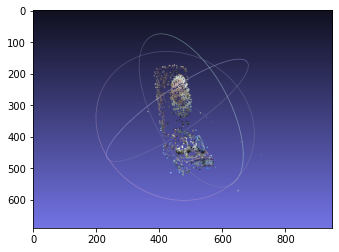

In [14]:
tri_img = cv2.imread(('./Triangulation_result.png'), cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(tri_img, cv2.COLOR_BGR2RGB))

Above is the mesh plot of the resulted `best_triangulation_result.ply` file.